In [1]:
import json, requests, time
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')


# Instalations and imports

In [55]:
!pip install matplotlib
!pip install seaborn
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.7 MB/s eta 0:00:0000:0100:010m


In [56]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data
Every time a user opens a mobile app, an auction is going on behind the scenes. The highest bidder gets to advertise his ad to the user.
## Auctions Table

In [2]:
sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    df_auc = pd.read_sql(sql_query, con=db_con)

df_auc

,id,eventTimestamp,unitDisplayType,brandName,bundleId,countryCode,deviceId,osAndVersion,bidFloorPrice,sentPrice
0,1,1657758857892,rewarded,Generic,com.loop.match3d,US,6a0a94554cf,Android-4.0,0.05,0.06
1,2,1657210707978,interstitial,Generic,com.loop.match3d,ZA,6a0b0e59f45,Android-4.0,0.01,0.16
2,3,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,6a0fa820c46,Android-10.0,0.05,0.06
3,4,1657386816882,interstitial,Huawei,com.tintash.nailsalon,IQ,6a142bdbea2,Android-9.0,0.01,0.05
4,5,1657211600823,banner,Generic,com.tilegarden.match3,US,6a16943a771,Android-4.0,0.01,0.03
...,...,...,...,...,...,...,...,...,...,...
41579,41580,1657731605063,banner,Generic,com.tilegarden.match3,NZ,80edf5837e8,Android-4.0,0.01,0.02
41580,41581,1657657131101,interstitial,Apple,1436213906,VN,80ee6a5eebf,iOS-13.6,0.01,0.90
41581,41582,1657156070854,rewarded,Generic,com.loop.match3d,US,80efe531afc,Android-4.0,0.05,0.69
41582,41583,1657659603568,banner,Apple,1502447854,US,80f02dd397f,iOS-15.0,0.01,0.10


# EDA
Exploring the data of auctions

In [53]:
df_auc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41584 entries, 0 to 41583
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               41584 non-null  int64  
 1   eventTimestamp   41584 non-null  object 
 2   unitDisplayType  41584 non-null  object 
 3   brandName        41584 non-null  object 
 4   bundleId         41584 non-null  object 
 5   countryCode      41584 non-null  object 
 6   deviceId         41584 non-null  object 
 7   osAndVersion     41584 non-null  object 
 8   bidFloorPrice    41584 non-null  float64
 9   sentPrice        41584 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 3.2+ MB


Lets see how the sent price distributes

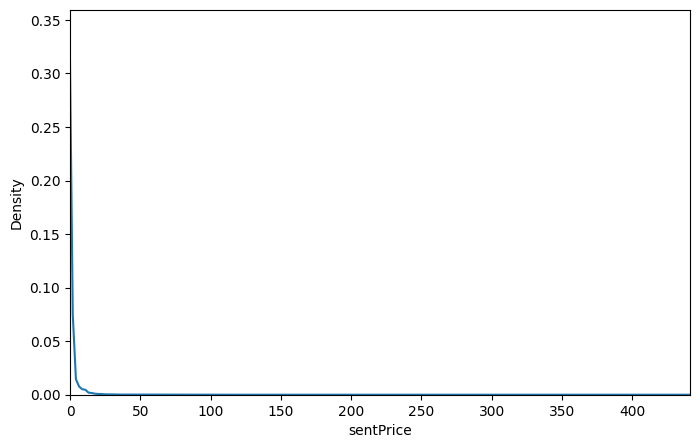

In [57]:

plt.figure(figsize=(8,5))
plt.xlim(0,np.max(df_auc['sentPrice'])) 
plt.xlabel('sentPrice')
plt.ylabel('Density')
sns.kdeplot(df_auc['sentPrice'])
plt.show()

As we can see there is a long tail of very high price auctions lets filter the data and keep the 99% at the end we can see what is the features of the rest 1% of hugh auctions

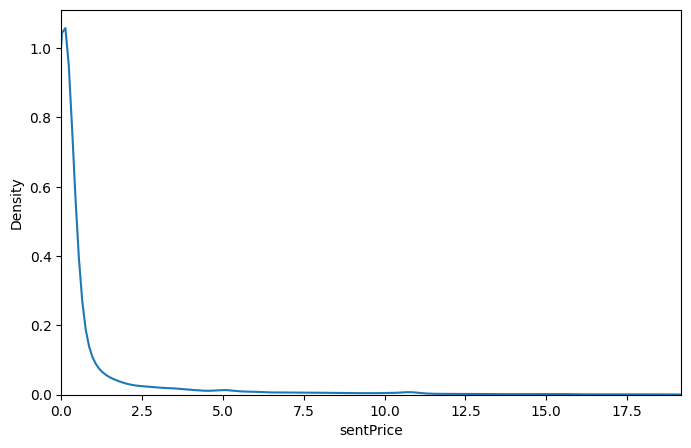

In [60]:
q = df_auc["sentPrice"].quantile(0.99)
df_filtered = df_auc[df_auc["sentPrice"]< q ] 
plt.figure(figsize=(8,5))
plt.xlim(0,np.max(df_filtered['sentPrice'])) 
plt.xlabel('sentPrice')
plt.ylabel('Density')
sns.kdeplot(df_filtered['sentPrice'])
plt.show()

There are also features as unitDisplayType,brandName using groupby method we can understand if there is a variance between this features using the count and std we can decide if they give us more explniability to the sent price

In [61]:
df_filtered.groupby(["bundleId","unitDisplayType"])["sentPrice"].agg( ['mean', 'min', 'max','std','count'])

mean   min    max       std  \
bundleId                    unitDisplayType                                    
1436213906                  interstitial     4.125326  0.01  18.97  4.145335   
                            rewarded         2.439332  0.01  19.13  3.638218   
1502447854                  banner           0.205629  0.01   7.82  0.396766   
                            interstitial     2.676969  0.01  16.22  3.098329   
                            rewarded         4.465664  0.01  19.01  4.244350   
1523081624                  banner           0.235398  0.01   3.48  0.350043   
                            interstitial     2.022347  0.01  17.27  3.676844   
                            rewarded         2.478602  0.01  18.94  4.350228   
1529614832                  banner           0.329252  0.01  12.83  0.970097   
                            interstitial     2.436522  0.02  13.27  3.417791   
                            rewarded         2.355476  0.02  18.00  3.881919   
1542256628                  banner           0.485537  0.05   2.48  0.500941   
                            interstitial     4.929487  0.09  18.29  5.547726   
                            rewarded         3.442917  0.05  10.53  3.449066   
1569586264                  interstitial     8.009500  0.45  18.39  5.150989   
                            rewarded         7.653077  1.16  17.76  4.640814   
1579489488                  banner           0.289212  0.05   9.50  0.812734   
                            interstitial     1.735556  0.05  15.93  2.816761   
                            rewarded         3.839310  0.06  16.76  5.245038   
1582745578                  banner           0.289167  0.05   2.31  0.511532   
                            rewarded         2.648333  0.06  18.91  5.506423   
1586795332                  banner           0.366098  0.05   3.81  0.518748   
                            interstitial     2.635055  0.05  16.82  4.409970   
                            rewarded         1.783889  0.05  13.24  3.223814   
com.AppIdeas.LevelUpRunner  banner           0.131547  0.05   3.32  0.231687   
com.YayySAL.DodgeAgent      banner           0.128158  0.05   4.75  0.242074   
                            interstitial     0.702584  0.05  17.88  1.839945   
                            rewarded         0.910698  0.05  18.06  2.146005   
com.kamilbilge.ropesavior3d banner           0.113202  0.05   2.87  0.215520   
                            interstitial     0.611508  0.05  18.87  1.410211   
                            rewarded         0.909099  0.05  19.17  2.146184   
com.loop.match3d            banner           0.131116  0.01   5.89  0.259186   
                            interstitial     1.030505  0.01  18.64  2.164414   
                            rewarded         2.059349  0.01  19.13  3.361323   
com.tilegarden.match3       banner           0.111371  0.01   4.25  0.248319   
                            interstitial     1.563503  0.01  19.18  3.075259   
                            rewarded         2.765650  0.01  18.57  4.295909   
com.tintash.nailsalon       banner           0.087617  0.01   3.07  0.215692   
                            interstitial     0.429000  0.01  18.68  1.424682   
                            rewarded         0.834757  0.01  18.02  2.242391   
com.volt.dresstoimpress     banner           0.048968  0.01   2.02  0.078794   
                            interstitial     1.705287  0.01   7.01  1.146098   
                            rewarded         0.780055  0.02   6.58  0.869840   
dovi.coalmining.inc         banner           0.132561  0.05   2.94  0.268324   
                            rewarded         0.587672  0.05  14.00  1.385001   
se.ace.fishinc              interstitial     1.230993  0.01  18.68  2.659123   
                            rewarded         1.677101  0.01  19.02  3.410550   

                                             count  
bundleId                    unitDisplayType         
1436213906            

In [62]:
df_filtered.groupby(["bundleId","unitDisplayType","brandName"])["sentPrice"].agg( ['mean', 'min', 'max','std','count'])

mean   min    max       std  \
bundleId       unitDisplayType brandName                                    
1436213906     interstitial    Apple      4.125326  0.01  18.97  4.145335   
               rewarded        Apple      2.439332  0.01  19.13  3.638218   
1502447854     banner          Apple      0.205629  0.01   7.82  0.396766   
               interstitial    Apple      2.676969  0.01  16.22  3.098329   
               rewarded        Apple      4.465664  0.01  19.01  4.244350   
...                                            ...   ...    ...       ...   
se.ace.fishinc rewarded        Vivo       0.823200  0.01  11.17  2.252726   
                               Vsmart     1.750000  1.75   1.75       NaN   
                               Wiko       4.950000  0.02  10.85  5.479772   
                               Xiaomi     0.476886  0.01  10.43  1.183735   
                               ZTE        2.964286  0.02  16.58  6.181127   

                                          count  
bundleId       unitDisplayType brandName         
1436213906     interstitial    Apple        659  
               rewarded        Apple        569  
1502447854     banner          Apple       2240  
               interstitial    Apple        287  
               rewarded        Apple        595  
...                                         ...  
se.ace.fishinc rewarded        Vivo          25  
                               Vsmart         1  
                               Wiko           3  
                               Xiaomi       273  
                               ZTE            7  

[936 rows x 5 columns]

In [ ]:
osAndVersion

We can defenitly see that 

In [4]:
df_auc.countryCode.unique(), str(len(df_auc.countryCode.unique())) +" Countrys"

(array(['US', 'ZA', 'BR', 'IQ', 'CL', 'MX', 'ID', 'VN', 'SV', 'GE', 'PH',
        'IN', 'IL', 'AU', 'NI', 'FR', 'UA', 'KR', 'TR', 'RU', 'GB', 'NL',
        'SK', 'IE', 'DE', 'EG', 'EC', 'JP', 'AZ', 'PK', 'BD', 'SE', 'AR',
        'CA', 'KW', 'BY', 'PT', 'NG', 'ES', 'AF', 'DZ', 'FI', 'IT', 'RO',
        'BE', 'CH', 'JO', 'PL', 'CR', 'TW', 'LU', 'HR', 'CO', 'MY', 'MA',
        'NO', 'SA', 'DK', 'MD', 'MU', 'NZ', 'PE', 'TH', 'MN', 'CZ', 'BO',
        'NE', 'BG', 'PA', 'KZ', 'PR', 'PG', 'GR', 'AT', 'TN', 'SI', 'CY',
        'LY', 'AE', 'AL', 'NP', 'GT', 'LT', 'RS', 'HU', 'DO', 'AM', 'LV',
        'KH', 'SG', 'HN', 'GM', 'KG', 'TJ', 'UZ', 'ZW', 'MK', 'GI', 'HK',
        'NA', 'VE', 'BB', 'CI', 'BF', 'CN', 'MM', 'IS', 'KE', 'OM', 'QA',
        'BA', 'SD', 'EE', 'PY', 'CG', 'PF', 'SO', 'LK', 'FJ', 'GH', 'DJ',
        'GY', 'ML', 'CD', 'UY', 'BH', 'ZM', 'BS', 'MW', 'BW', 'TT', 'TZ',
        'AO', 'ME', 'SM', 'CV', 'MT', 'ST', 'UG', 'JM', 'MZ', 'GL', 'CM',
        'GN', 'TM', 'MV', 'TG', 'PS', 

In [6]:
df_auc.groupby(["bundleId","unitDisplayType","countryCode"])["sentPrice"].agg( ['mean', 'min', 'max','std','count']) 

mean   min    max        std  \
bundleId       unitDisplayType countryCode                                     
1436213906     interstitial    AE           6.856667  0.02  33.03  13.216506   
                               AM           0.656667  0.55   0.72   0.092916   
                               AR           0.130000  0.13   0.13        NaN   
                               AU           1.822424  0.02  13.10   3.505906   
                               BA           0.040000  0.04   0.04        NaN   
...                                              ...   ...    ...        ...   
se.ace.fishinc rewarded        UY           0.230000  0.11   0.36   0.125300   
                               UZ           0.103333  0.09   0.13   0.023094   
                               VE           0.200000  0.03   0.72   0.269221   
                               VN           1.035758  0.02   3.45   0.802115   
                               ZA           1.768333  0.20   5.22   1.743762   

                                            count  
bundleId       unitDisplayType countryCode         
1436213906     interstitial    AE               6  
                               AM               3  
                               AR               1  
                               AU              33  
                               BA               1  
...                                           ...  
se.ace.fishinc rewarded        UY               3  
                               UZ               3  
                               VE               6  
                               VN              33  
                               ZA              12  

[2605 rows x 5 columns]

In [7]:
df_auc.groupby(["bundleId","unitDisplayType","brandName","countryCode"])["sentPrice"].agg( ['mean', 'min', 'max','std','count']) 

mean   min    max  \
bundleId       unitDisplayType brandName countryCode                          
1436213906     interstitial    Apple     AE           6.856667  0.02  33.03   
                                         AM           0.656667  0.55   0.72   
                                         AR           0.130000  0.13   0.13   
                                         AU           1.822424  0.02  13.10   
                                         BA           0.040000  0.04   0.04   
...                                                        ...   ...    ...   
se.ace.fishinc rewarded        Xiaomi    VN           1.920000  1.53   2.36   
                               ZTE       BO           0.080000  0.08   0.08   
                                         MX           0.020000  0.02   0.02   
                                         UA           0.035000  0.02   0.05   
                                         US           6.860000  0.02  16.58   

                                                            std  count  
bundleId       unitDisplayType brandName countryCode                    
1436213906     interstitial    Apple     AE           13.216506      6  
                                         AM            0.092916      3  
                                         AR                 NaN      1  
                                         AU            3.505906     33  
                                         BA                 NaN      1  
...                                                         ...    ...  
se.ace.fishinc rewarded        Xiaomi    VN            0.417253      3  
                               ZTE       BO                 NaN      1  
                                         MX                 NaN      1  
                                         UA            0.021213      2  
                                         US            8.647497      3  

[7245 rows x 5 columns]

## App Vectors table
We've gathered the first few sentences from the app store description and embedded it with a [model](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [9]:
sql_query = f'''
SELECT
    *
FROM app_vectors
'''
has_embedding = False
while not has_embedding:
    with engine.connect() as db_con:
        df_app = pd.read_sql(sql_query, con=db_con)
    has_embedding = (~df_app["embedding"].isna()).all()
    if not has_embedding:
        print("Waiting for embeddings...")
        time.sleep(15)

df_app


,id,bundleId,content,embedding
0,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.3168352,0.6250086,-0.12035585,0.21742323,-0..."
1,2,com.YayySAL.DodgeAgent,"Your mission, should you choose to accept it, ...","[0.5411282,0.7446755,-0.5817451,0.95967793,0.0..."
2,3,com.tintash.nailsalon,It is manicure madness over here and it�s your...,"[0.31176656,0.6059464,-1.1395648,0.07631045,-0..."
3,4,com.tilegarden.match3,\nIf you enjoy playing Match 3 tile & mahjong ...,"[0.050924458,1.0967327,-0.30831614,0.13220672,..."
4,6,com.AppIdeas.LevelUpRunner,"Are you a real hero? Are you the strongest, th...","[0.897561,0.46442518,-0.18019226,1.2617054,0.0..."
5,17,1582745578,Dominate the coal industry and become the next...,"[0.88490486,0.65851957,-0.3386694,0.18323663,0..."
6,18,1569586264,Choose the appropriate outfit to make it throu...,"[0.2000534,0.36083463,-0.13792263,0.34308642,-..."
7,5,com.kamilbilge.ropesavior3d,Become the hero we need in this tangled puzzle...,"[0.5112473,0.5128061,-0.05630451,1.2819325,0.1..."
8,7,se.ace.fishinc,Gather your riches and travel across the open ...,"[0.73094344,0.4112171,-0.6196014,0.53501374,0...."
9,8,com.volt.dresstoimpress,\nChoose the appropriate outfit to make it thr...,"[0.2000534,0.36083463,-0.13792263,0.34308642,-..."


We can use the `<=>` operator to run vector search within the database

In [ ]:


G = nx.Graph()
  #Create nodes
  for i in net_idx:
    G.add_node(i)
  #Add edges no removing of self nodes
  for i in range(matrix_new.shape[0]):
   for j in range(matrix_new.shape[1]):
     if matrix_new.iloc[i,j] :
       G.add_edge(i, j)
       G[i][j]["weight"] = matrix_new.iloc[i,j]
  return G

G = nx.gnp_random_graph(15, 0.2, directed=True)
node_degree = dict(G.degree(weight='weight'))

# A) Precompute node positions, and then manually over-ride some node positions.
node_positions = nx.spring_layout(G)
node_positions[0] = (0.5, 0.5) # by default, networkx plots on a canvas with the origin at (0, 0) and a width and height of 1; (0.5, 0.5) is hence the center
nx.draw(G, pos=node_positions, node_size=[100 * node_degree[node] for node in G])
plt.show()

In [25]:

vec = json.loads(df_app.embedding[13]) # get the first embedding
print ("Embedding size: {l}".format(l=len(vec)))

sql_query = f'''
SELECT
    "bundleId"
FROM app_vectors
ORDER BY embedding<=>'{json.dumps(vec)}'
'''
with engine.connect() as db_con:
    df1 = pd.read_sql(sql_query, con=db_con)

df1


Embedding size: 1024


,bundleId
0,1502447854
1,com.loop.match3d
2,1529614832
3,com.tilegarden.match3
4,com.kamilbilge.ropesavior3d
5,1579489488
6,1436213906
7,com.volt.dresstoimpress
8,1569586264
9,1586795332


In [26]:
sql_query = f'''
SELECT 1 - (embedding<=>'{json.dumps(vec)}')  AS cosine_similarity,"bundleId" FROM app_vectors 
'''
#WHERE (1 - (embedding<=>'{json.dumps(vec)}'))>0.6
with engine.connect() as db_con:
    df1 = pd.read_sql(sql_query, con=db_con)

df1


,cosine_similarity,bundleId
0,0.922637,com.loop.match3d
1,0.504298,com.YayySAL.DodgeAgent
2,0.497849,com.tintash.nailsalon
3,0.661645,com.tilegarden.match3
4,0.521311,com.AppIdeas.LevelUpRunner
5,0.490862,1582745578
6,0.532882,1569586264
7,0.589520,com.kamilbilge.ropesavior3d
8,0.519569,se.ace.fishinc
9,0.532882,com.volt.dresstoimpress


In [24]:
import numpy as np 

avg_price = []
for bid in df1["bundleId"]:
  avg_price.append(np.mean(df_auc[df_auc.bundleId ==bid]["sentPrice"]))
df1["avg_price"] = avg_price
df1

,cosine_similarity,bundleId,avg_price
0,1.000000,com.loop.match3d,1.420811
1,0.480975,com.YayySAL.DodgeAgent,0.445529
2,0.459344,com.tintash.nailsalon,0.300057
3,0.658637,com.tilegarden.match3,2.297261
4,0.509649,com.AppIdeas.LevelUpRunner,0.131547
5,0.469741,1582745578,2.179091
6,0.501801,1569586264,18.900179
7,0.557880,com.kamilbilge.ropesavior3d,0.451491
8,0.502924,se.ace.fishinc,1.831922
9,0.501801,com.volt.dresstoimpress,0.445255


# What you need to do
## The hypothesis
We assume that apps with similar desciptions, would have a similar asking price in the auctions (`sentPrice` column).

Use cosine similarity (`<=>`) on the embeddings to find similar apps, and any statistical tools you find suitable to prove or disprove this hypothesis.

## Is it consistent?
There are several other features in the auctions table (such as `CountryCode` and `OS`), 
Do your findings hold for those as well?

In [ ]:
# TODO: Please write your analysis here
#when considering advertising we need to understand who is the target audieance of the company
#maybe the company focusing on larger countrys or on ppl with iphone unser the assumption they are 
#more willing to spend money or have more money to spend 
#1. lets find the outlayers of any sent price any price 2.5 more than the mean price in that country or region
#2. let see if any company has more inclenation to advertise in country/OS/type

In [92]:
#url = "https://www.iban.com/country-codes"
from bs4 import BeautifulSoup

url = "https://worldpopulationreview.com/countries/by-gdp"
response = requests.get(url)
soup = BeautifulSoup(response.content)
# print(soup)
# urlList = soup.select('\"continent\":\"World\",\"data\":')
df = pd.json_normalize(
    json.loads(
        BeautifulSoup(
            requests.get(url).text 
        ).select_one('_next_static_chuncks_').text)['props']['pageProps']['data']
)
df[['continent', 'country', 'pop','imfGDP', 'unGDP', 'gdpPerCapita']]



# data = []
# print(urlList)
# for url in urlList:
#     try:
#         data.append(pd.read_html(url)[0])
#     except:
#         print(f'No tables found:{url}')

# # pd.concat(data)
# data

SSLError: HTTPSConnectionPool(host='worldpopulationreview.com', port=443): Max retries exceeded with url: /countries/by-gdp (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))

In [56]:
BeautifulSoup(requests.get(url).text)

<!DOCTYPE html>
<html lang="en"><head><meta charset="utf-8"/><meta content="width=device-width, initial-scale=1" name="viewport"/><link crossorigin="" data-precedence="next" href="/_next/static/css/2eb2a59ffd611e63.css" rel="stylesheet"/><link as="script" crossorigin="" fetchpriority="low" href="/_next/static/chunks/webpack-1a7ad1aeb5075eec.js" rel="preload"/><script async="" crossorigin="" src="/_next/static/chunks/fd9d1056-d380c48014b3e4e7.js"></script><script async="" crossorigin="" src="/_next/static/chunks/2472-6e758f1ffa73dfe8.js"></script><script async="" crossorigin="" src="/_next/static/chunks/main-app-8ed6d57d180fb331.js"></script><script async="" src="/_next/static/chunks/2122-c5f834f82b72b85c.js"></script><script async="" src="/_next/static/chunks/3994-368125a51e867871.js"></script><script async="" src="/_next/static/chunks/4311-483ce19e91471427.js"></script><script async="" src="/_next/static/chunks/app/layout-4f95407014239da6.js"></script><script async="" src="/_next/stat

In [75]:
node = requests.get(url)
if node is not None:
    ementa = node.text
else:
    ementa = None
node = BeautifulSoup(ementa).select_one('#__next_data__') ##__NEXT_DATA__
if node is not None:
    ementa1 = node.text['props']['pageProps']['data']
else:
    ementa1 = None
df = pd.json_normalize(
    json.loads(ementa1))
df[['continent', 'country', 'pop','imfGDP', 'unGDP', 'gdpPerCapita']]

TypeError: the JSON object must be str, bytes or bytearray, not NoneType